In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
print(tf.__version__)

2.9.0


In [3]:
#import tensorflow.contrib.slim as slim
import tf_slim as slim


In [4]:
import sys
sys.path.insert(0, '../')

In [5]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"


import numpy as np
import tensorflow as tf
import functools
import matplotlib.pyplot as plt
from copy import deepcopy

from gantools import utils
from gantools import plot
from gantools.model import WGAN
from gantools.gansystem import GANsystem


from cosmotools.metric import evaluation
from cosmotools.model import CosmoWGAN
from cosmotools.data import load
from cosmotools.data import fmap

# Parameters

In [6]:
ns = 32 # Resolution of the image
try_resume = False # Try to resume previous training step
Mpch = 70 # Type of dataset (select 70 or 350)


forward = fmap.stat_forward
backward = fmap.stat_backward
def non_lin(x):
    return tf.nn.relu(x)

# Data handling

Load the data

In [7]:
dataset = load.load_nbody_dataset(ncubes=10, spix=ns, Mpch=Mpch, forward_map=forward)

Select 10 cubes out of 10.
images shape =  (10, 256, 256, 256)


In [8]:
# The dataset can return an iterator.
it = dataset.iter(10)
print(next(it).shape)
del it

(10, 32, 32, 1)


In [9]:
# Get all the data
X = dataset.get_all_data().flatten()

In [10]:
# Check that the backward maps invert the forward map.
assert(np.sum(np.abs(forward(np.round(backward(X))))-X)==0)

Display the histogram of the pixel densities after the forward map

min: 0.0
max: 5.014508247375488


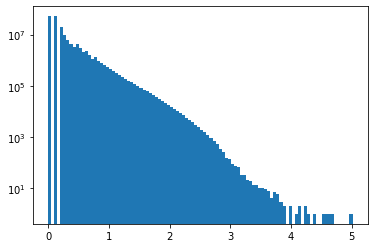

In [11]:
plt.hist(X, 100)
print('min: {}'.format(np.min(X)))
print('max: {}'.format(np.max(X)))
plt.yscale('log')

In [12]:
# to free some memory
del X

Let us plot 16 images

Text(0.5, 1.0, 'Real samples')

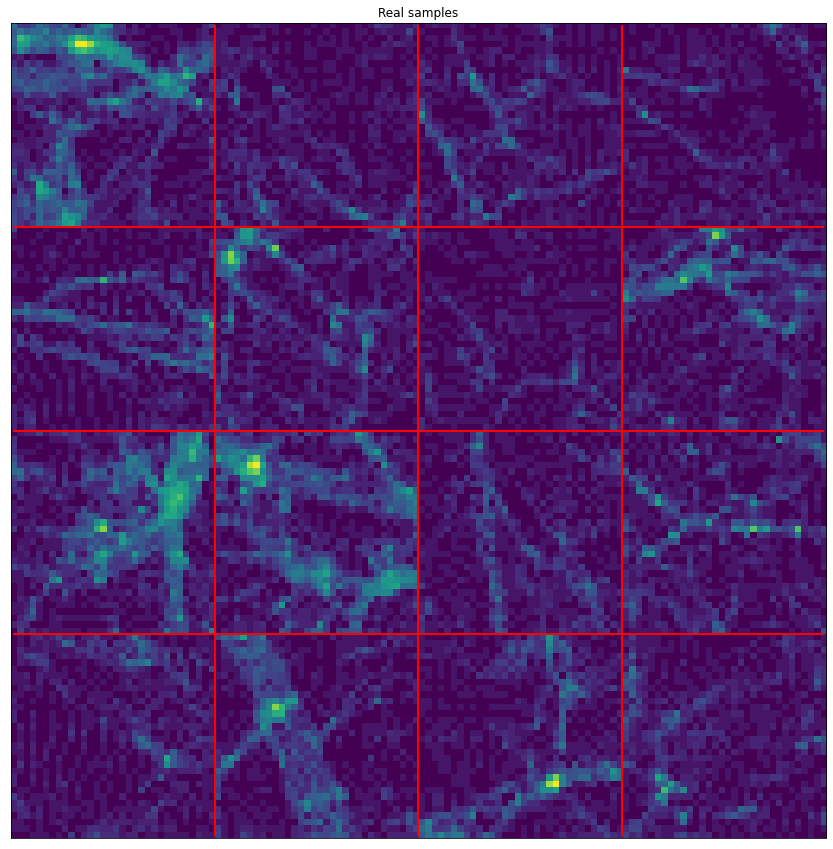

In [13]:
plt.figure(figsize=(15,15))
plot.draw_images(dataset.get_samples(N=16),nx=4,ny=4);
plt.title("Real samples")

# Define parameters for the WGAN

In [14]:
global_path = 'saved_results'
name = 'WGAN{}'.format(ns) + '_' + '2D_simple'

## Parameters

In [15]:
bn = False

md=32

params_discriminator = dict()
params_discriminator['stride'] = [1, 2, 2, 2, 1]
params_discriminator['nfilter'] = [md, 2*md, 4*md, 2*md, md]
params_discriminator['shape'] = [[4, 4],[4, 4],[4, 4], [4, 4], [4, 4]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn, bn ]
params_discriminator['full'] = []
params_discriminator['minibatch_reg'] = False
params_discriminator['summary'] = True
params_discriminator['data_size'] = 2
params_discriminator['inception'] = False
params_discriminator['spectral_norm'] = False
params_discriminator['fft_features'] = False
params_discriminator['psd_features'] = False

params_generator = dict()
params_generator['stride'] = [1, 2, 2, 2, 1]
params_generator['latent_dim'] = ns*2
params_generator['in_conv_shape'] =[ns//8,ns//8]
params_generator['nfilter'] = [md, 2*md, 4*md, 2*md, 1]
params_generator['shape'] = [[4, 4],[4, 4], [4, 4],[4, 4],[4, 4]]
params_generator['batch_norm'] = [bn, bn, bn,bn ]
params_generator['full'] = [(ns//8)**2 *8]
params_generator['summary'] = True
params_generator['non_lin'] = None
params_generator['data_size'] = 2
params_generator['inception'] = False
params_generator['spectral_norm'] = False


params_optimization = dict()
params_optimization['batch_size'] = 32
params_optimization['epoch'] = (ns**2)//64
params_optimization['n_critic'] = 5
# params_optimization['generator'] = dict()
# params_optimization['generator']['optimizer'] = 'adam'
# params_optimization['generator']['kwargs'] = {'beta1':0, 'beta2':0.9}
# params_optimization['generator']['learning_rate'] = 0.0004
# params_optimization['discriminator'] = dict()
# params_optimization['discriminator']['optimizer'] = 'adam'
# params_optimization['discriminator']['kwargs'] = {'beta1':0, 'beta2':0.9}
# params_optimization['discriminator']['learning_rate'] = 0.0001

# Cosmology parameters
params_cosmology = dict()
params_cosmology['forward_map'] = forward
params_cosmology['backward_map'] = backward


# all parameters
params = dict()
params['net'] = dict() # All the parameters for the model
params['net']['generator'] = params_generator
params['net']['discriminator'] = params_discriminator
params['net']['cosmology'] = params_cosmology # Parameters for the cosmological summaries
params['net']['prior_distribution'] = 'gaussian'
params['net']['shape'] = [ns, ns, 1] # Shape of the image
params['net']['loss_type'] = 'wasserstein' # loss ('hinge' or 'wasserstein')
params['net']['gamma_gp'] = 10 # Gradient penalty

params['optimization'] = params_optimization
params['summary_every'] = 500 # Tensorboard summaries every ** iterations
params['print_every'] = 50 # Console summaries every ** iterations
params['save_every'] = 2000 # Save the model every ** iterations
params['summary_dir'] = os.path.join(global_path, name +'_summary/')
params['save_dir'] = os.path.join(global_path, name + '_checkpoints/')
params['Nstats'] = (64*32*32)//ns



In [16]:
resume, params = utils.test_resume(try_resume, params)
# If a model is reloaded and some parameters have to be changed, then it should be done here.
# For example, setting the number of epoch to 10 would be:
params['optimization']['epoch'] = 1 #40


# Build the model

In [17]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 

In [18]:
tf.compat.v1.disable_eager_execution()

In [19]:
wgan = GANsystem(CosmoWGAN, params)

Generator 
--------------------------------------------------
     The input is of size (None, 64)
     0 Full layer with 128 outputs
         Size of the variables: (None, 128)
     Reshape to (None, 4, 4, 8)
     1 Deconv layer with 32 channels
         Non linearity applied
         Size of the variables: (None, 4, 4, 32)
     2 Deconv layer with 64 channels
         Non linearity applied
         Size of the variables: (None, 8, 8, 64)
     3 Deconv layer with 128 channels
         Non linearity applied
         Size of the variables: (None, 16, 16, 128)
     4 Deconv layer with 64 channels
         Non linearity applied
         Size of the variables: (None, 32, 32, 64)
     5 Deconv layer with 1 channels
         Size of the variables: (None, 32, 32, 1)
     The output is of size (None, 32, 32, 1)
--------------------------------------------------

Discriminator 
--------------------------------------------------
     The input is of size (None, 32, 32, 1)
     0 Conv layer with 

# Train the model

In [20]:
wgan.train(dataset, resume=resume)

Compute real statistics: descriptives/mean_l2
Compute real statistics: descriptives/var_l2
Compute real statistics: descriptives/min_l2
Compute real statistics: descriptives/max_l2
Compute real statistics: descriptives/kurtosis_l2
Compute real statistics: descriptives/skewness_l2
Compute real statistics: descriptives/median_l2
Compute real statistics: cosmology/mass_histogram_l2log
Compute real statistics: cosmology/peak_histogram_l2log


/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:294: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array(pool.map(peak_count_arg, dat))
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:298: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array([np.log(pa+np.e) for pa in peak_arr])


Compute real statistics: cosmology/psd_l2log


/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(pool.map(hist_func, peak_arr))
2022-06-03 12:34:32.908422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-03 12:34:32.993967: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Erase recursively directory: saved_results/WGAN32_2D_simple_checkpoints/
Start training
 * Epoch: [ 0] [  50/5120] Counter:50	( 3.4 min	7.921 examples/sec	4.04 sec/batch)
   Disc batch loss:-1.12106788	Disc epoch loss:0.75615650
   Gen batch loss:0.01490525	Gen epoch loss:0.01099408
 * Epoch: [ 0] [ 100/5120] Counter:100	( 6.5 min	8.419 examples/sec	3.80 sec/batch)
   Disc batch loss:-1.55510259	Disc epoch loss:-0.33553568
   Gen batch loss:-0.05286560	Gen epoch loss:-0.01113205
 * Epoch: [ 0] [ 150/5120] Counter:150	( 9.4 min	9.221 examples/sec	3.47 sec/batch)
   Disc batch loss:-1.29880023	Disc epoch loss:-0.69458807
   Gen batch loss:-0.25641239	Gen epoch loss:-0.04751343
 * Epoch: [ 0] [ 200/5120] Counter:200	(12.3 min	9.281 examples/sec	3.45 sec/batch)
   Disc batch loss:-1.16845119	Disc epoch loss:-0.81038315
   Gen batch loss:-0.54409659	Gen epoch loss:-0.13953572
 * Epoch: [ 0] [ 250/5120] Counter:250	(15.1 min	9.685 examples/sec	3.30 sec/batch)
   Disc batch loss:-1.14267278	D

/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:294: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array(pool.map(peak_count_arg, dat))
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:298: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array([np.log(pa+np.e) for pa in peak_arr])
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 * Epoch: [ 0] [ 550/5120] Counter:550	(34.1 min	6.806 examples/sec	4.70 sec/batch)
   Disc batch loss:-0.73123360	Disc epoch loss:-0.97703652
   Gen batch loss:-0.86385083	Gen epoch loss:-0.54561871
 * Epoch: [ 0] [ 600/5120] Counter:600	(36.6 min	10.906 examples/sec	2.93 sec/batch)
   Disc batch loss:-0.88804090	Disc epoch loss:-0.96263314
   Gen batch loss:-0.97727311	Gen epoch loss:-0.57604167
 * Epoch: [ 0] [ 650/5120] Counter:650	(39.3 min	9.716 examples/sec	3.29 sec/batch)
   Disc batch loss:-0.78090501	Disc epoch loss:-0.95241349
   Gen batch loss:-0.78776455	Gen epoch loss:-0.59577792
 * Epoch: [ 0] [ 700/5120] Counter:700	(42.3 min	8.963 examples/sec	3.57 sec/batch)
   Disc batch loss:-0.74820095	Disc epoch loss:-0.94107283
   Gen batch loss:-0.81624329	Gen epoch loss:-0.61382939
 * Epoch: [ 0] [ 750/5120] Counter:750	(45.7 min	7.848 examples/sec	4.08 sec/batch)
   Disc batch loss:-0.73680514	Disc epoch loss:-0.93009900
   Gen batch loss:-0.64794540	Gen epoch loss:-0.63326126

/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:294: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array(pool.map(peak_count_arg, dat))
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:298: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array([np.log(pa+np.e) for pa in peak_arr])
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 * Epoch: [ 0] [1050/5120] Counter:1050	(61.7 min	8.650 examples/sec	3.70 sec/batch)
   Disc batch loss:-0.59938544	Disc epoch loss:-0.86630861
   Gen batch loss:-0.74595881	Gen epoch loss:-0.74679032
 * Epoch: [ 0] [1100/5120] Counter:1100	(63.9 min	12.588 examples/sec	2.54 sec/batch)
   Disc batch loss:-0.66300935	Disc epoch loss:-0.85641593
   Gen batch loss:-0.50534129	Gen epoch loss:-0.75798518
 * Epoch: [ 0] [1150/5120] Counter:1150	(65.8 min	13.518 examples/sec	2.37 sec/batch)
   Disc batch loss:-0.62489176	Disc epoch loss:-0.84673104
   Gen batch loss:-1.02500927	Gen epoch loss:-0.76581593
 * Epoch: [ 0] [1200/5120] Counter:1200	(67.9 min	12.678 examples/sec	2.52 sec/batch)
   Disc batch loss:-0.61350024	Disc epoch loss:-0.83684575
   Gen batch loss:-0.69207358	Gen epoch loss:-0.77064613
 * Epoch: [ 0] [1250/5120] Counter:1250	(70.0 min	13.031 examples/sec	2.46 sec/batch)
   Disc batch loss:-0.59907335	Disc epoch loss:-0.82749247
   Gen batch loss:-0.81185007	Gen epoch loss:-0.

/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:294: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array(pool.map(peak_count_arg, dat))
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:298: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array([np.log(pa+np.e) for pa in peak_arr])
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 * Epoch: [ 0] [1550/5120] Counter:1550	(83.0 min	9.053 examples/sec	3.53 sec/batch)
   Disc batch loss:-0.57075417	Disc epoch loss:-0.77679405
   Gen batch loss:-0.93272483	Gen epoch loss:-0.77291375
 * Epoch: [ 0] [1600/5120] Counter:1600	(85.0 min	13.583 examples/sec	2.36 sec/batch)
   Disc batch loss:-0.52185208	Disc epoch loss:-0.76951564
   Gen batch loss:-0.58156013	Gen epoch loss:-0.76886100
 * Epoch: [ 0] [1650/5120] Counter:1650	(87.0 min	13.464 examples/sec	2.38 sec/batch)
   Disc batch loss:-0.51353014	Disc epoch loss:-0.76236391
   Gen batch loss:-0.49527046	Gen epoch loss:-0.76458151
 * Epoch: [ 0] [1700/5120] Counter:1700	(89.0 min	13.002 examples/sec	2.46 sec/batch)
   Disc batch loss:-0.49002868	Disc epoch loss:-0.75533761
   Gen batch loss:-0.28130203	Gen epoch loss:-0.75895224
 * Epoch: [ 0] [1750/5120] Counter:1750	(90.9 min	13.813 examples/sec	2.32 sec/batch)
   Disc batch loss:-0.54652596	Disc epoch loss:-0.74851248
   Gen batch loss:-0.74455845	Gen epoch loss:-0.

/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:294: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array(pool.map(peak_count_arg, dat))
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:298: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array([np.log(pa+np.e) for pa in peak_arr])
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

INFO:tensorflow:saved_results/WGAN32_2D_simple_checkpoints/wgan-2000.data-00000-of-00001
INFO:tensorflow:7700
INFO:tensorflow:saved_results/WGAN32_2D_simple_checkpoints/wgan-2000.index
INFO:tensorflow:7700
INFO:tensorflow:saved_results/WGAN32_2D_simple_checkpoints/wgan-2000.meta
INFO:tensorflow:8400
Model saved!
 * Epoch: [ 0] [2050/5120] Counter:2050	(104.1 min	9.101 examples/sec	3.52 sec/batch)
   Disc batch loss:-0.54587221	Disc epoch loss:-0.71422560
   Gen batch loss:-0.76485384	Gen epoch loss:-0.72852395
 * Epoch: [ 0] [2100/5120] Counter:2100	(106.1 min	12.937 examples/sec	2.47 sec/batch)
   Disc batch loss:-0.53744990	Disc epoch loss:-0.70943054
   Gen batch loss:-0.34904730	Gen epoch loss:-0.72575416
 * Epoch: [ 0] [2150/5120] Counter:2150	(108.2 min	12.993 examples/sec	2.46 sec/batch)
   Disc batch loss:-0.53704554	Disc epoch loss:-0.70480744
   Gen batch loss:-0.78000736	Gen epoch loss:-0.72327502
 * Epoch: [ 0] [2200/5120] Counter:2200	(110.2 min	13.009 examples/sec	2.46 se

/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:294: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array(pool.map(peak_count_arg, dat))
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:298: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array([np.log(pa+np.e) for pa in peak_arr])
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 * Epoch: [ 0] [2550/5120] Counter:2550	(129.0 min	4.139 examples/sec	7.73 sec/batch)
   Disc batch loss:-0.48841229	Disc epoch loss:-0.67213754
   Gen batch loss:-0.66991711	Gen epoch loss:-0.70567190
 * Epoch: [ 0] [2600/5120] Counter:2600	(133.6 min	5.901 examples/sec	5.42 sec/batch)
   Disc batch loss:-0.51716268	Disc epoch loss:-0.66879118
   Gen batch loss:-0.31063852	Gen epoch loss:-0.70330333
 * Epoch: [ 0] [2650/5120] Counter:2650	(142.6 min	2.953 examples/sec	10.84 sec/batch)
   Disc batch loss:-0.50611967	Disc epoch loss:-0.66550548
   Gen batch loss:-0.77751666	Gen epoch loss:-0.70168536
 * Epoch: [ 0] [2700/5120] Counter:2700	(144.8 min	12.204 examples/sec	2.62 sec/batch)
   Disc batch loss:-0.47445238	Disc epoch loss:-0.66229670
   Gen batch loss:-0.48675489	Gen epoch loss:-0.69983844
 * Epoch: [ 0] [2750/5120] Counter:2750	(146.8 min	13.376 examples/sec	2.39 sec/batch)
   Disc batch loss:-0.50011158	Disc epoch loss:-0.65918692
   Gen batch loss:-0.66642082	Gen epoch loss

/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:294: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array(pool.map(peak_count_arg, dat))
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:298: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array([np.log(pa+np.e) for pa in peak_arr])
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 * Epoch: [ 0] [3050/5120] Counter:3050	(163.7 min	5.312 examples/sec	6.02 sec/batch)
   Disc batch loss:-0.50701416	Disc epoch loss:-0.64148335
   Gen batch loss:-0.80974460	Gen epoch loss:-0.68808536
 * Epoch: [ 0] [3100/5120] Counter:3100	(167.0 min	7.891 examples/sec	4.06 sec/batch)
   Disc batch loss:-0.51263583	Disc epoch loss:-0.63895085
   Gen batch loss:-0.39681178	Gen epoch loss:-0.68625391
 * Epoch: [ 0] [3150/5120] Counter:3150	(170.5 min	7.597 examples/sec	4.21 sec/batch)
   Disc batch loss:-0.52600330	Disc epoch loss:-0.63652956
   Gen batch loss:-0.79833066	Gen epoch loss:-0.68459684
 * Epoch: [ 0] [3200/5120] Counter:3200	(173.9 min	7.873 examples/sec	4.06 sec/batch)
   Disc batch loss:-0.49390686	Disc epoch loss:-0.63403600
   Gen batch loss:-0.42122501	Gen epoch loss:-0.68258303
 * Epoch: [ 0] [3250/5120] Counter:3250	(177.5 min	7.398 examples/sec	4.33 sec/batch)
   Disc batch loss:-0.43566993	Disc epoch loss:-0.63161895
   Gen batch loss:-0.35266954	Gen epoch loss:-0

/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:294: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array(pool.map(peak_count_arg, dat))
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:298: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array([np.log(pa+np.e) for pa in peak_arr])
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 * Epoch: [ 0] [3550/5120] Counter:3550	(197.4 min	5.642 examples/sec	5.67 sec/batch)
   Disc batch loss:-0.45363793	Disc epoch loss:-0.61828781
   Gen batch loss:-0.51095480	Gen epoch loss:-0.66172696
 * Epoch: [ 0] [3600/5120] Counter:3600	(200.3 min	9.141 examples/sec	3.50 sec/batch)
   Disc batch loss:-0.44952968	Disc epoch loss:-0.61623582
   Gen batch loss:-0.11942693	Gen epoch loss:-0.65778124
 * Epoch: [ 0] [3650/5120] Counter:3650	(203.5 min	8.335 examples/sec	3.84 sec/batch)
   Disc batch loss:-0.42282298	Disc epoch loss:-0.61422158
   Gen batch loss:-0.33943605	Gen epoch loss:-0.65413468
 * Epoch: [ 0] [3700/5120] Counter:3700	(206.7 min	8.217 examples/sec	3.89 sec/batch)
   Disc batch loss:-0.47315967	Disc epoch loss:-0.61212206
   Gen batch loss:-0.42600918	Gen epoch loss:-0.65024595
 * Epoch: [ 0] [3750/5120] Counter:3750	(210.0 min	8.143 examples/sec	3.93 sec/batch)
   Disc batch loss:-0.39756417	Disc epoch loss:-0.61011429
   Gen batch loss:-0.35023683	Gen epoch loss:-0

/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:294: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array(pool.map(peak_count_arg, dat))
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:298: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array([np.log(pa+np.e) for pa in peak_arr])
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

INFO:tensorflow:saved_results/WGAN32_2D_simple_checkpoints/wgan-4000.meta
INFO:tensorflow:700
INFO:tensorflow:saved_results/WGAN32_2D_simple_checkpoints/wgan-4000.data-00000-of-00001
INFO:tensorflow:8400
INFO:tensorflow:saved_results/WGAN32_2D_simple_checkpoints/wgan-4000.index
INFO:tensorflow:8400
Model saved!
 * Epoch: [ 0] [4050/5120] Counter:4050	(230.7 min	5.229 examples/sec	6.12 sec/batch)
   Disc batch loss:-0.46126747	Disc epoch loss:-0.59870886
   Gen batch loss:-0.06125998	Gen epoch loss:-0.61777059
 * Epoch: [ 0] [4100/5120] Counter:4100	(234.1 min	7.769 examples/sec	4.12 sec/batch)
   Disc batch loss:-0.46290922	Disc epoch loss:-0.59694869
   Gen batch loss:-0.33709958	Gen epoch loss:-0.61234483
 * Epoch: [ 0] [4150/5120] Counter:4150	(236.7 min	10.393 examples/sec	3.08 sec/batch)
   Disc batch loss:-0.43077427	Disc epoch loss:-0.59526667
   Gen batch loss:-0.16816141	Gen epoch loss:-0.60688329
 * Epoch: [ 0] [4200/5120] Counter:4200	(238.9 min	11.996 examples/sec	2.67 sec/

/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:294: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array(pool.map(peak_count_arg, dat))
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:298: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array([np.log(pa+np.e) for pa in peak_arr])
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 * Epoch: [ 0] [4550/5120] Counter:4550	(260.2 min	7.442 examples/sec	4.30 sec/batch)
   Disc batch loss:-0.47458830	Disc epoch loss:-0.58249971
   Gen batch loss:-0.27767169	Gen epoch loss:-0.56127450
 * Epoch: [ 0] [4600/5120] Counter:4600	(262.6 min	11.021 examples/sec	2.90 sec/batch)
   Disc batch loss:-0.46198076	Disc epoch loss:-0.58107319
   Gen batch loss:0.25957525	Gen epoch loss:-0.55569769
 * Epoch: [ 0] [4650/5120] Counter:4650	(264.9 min	11.425 examples/sec	2.80 sec/batch)
   Disc batch loss:-0.39883232	Disc epoch loss:-0.57965948
   Gen batch loss:-0.17561045	Gen epoch loss:-0.55051457
 * Epoch: [ 0] [4700/5120] Counter:4700	(267.5 min	10.540 examples/sec	3.04 sec/batch)
   Disc batch loss:-0.41547704	Disc epoch loss:-0.57816982
   Gen batch loss:-0.21255444	Gen epoch loss:-0.54532828
 * Epoch: [ 0] [4750/5120] Counter:4750	(269.8 min	11.322 examples/sec	2.83 sec/batch)
   Disc batch loss:-0.45397407	Disc epoch loss:-0.57657652
   Gen batch loss:0.10099548	Gen epoch loss:

/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:294: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array(pool.map(peak_count_arg, dat))
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:298: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array([np.log(pa+np.e) for pa in peak_arr])
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 * Epoch: [ 0] [5050/5120] Counter:5050	(285.0 min	7.910 examples/sec	4.05 sec/batch)
   Disc batch loss:-0.42078039	Disc epoch loss:-0.56829495
   Gen batch loss:0.08381945	Gen epoch loss:-0.51068110
 * Epoch: [ 0] [5100/5120] Counter:5100	(287.3 min	11.642 examples/sec	2.75 sec/batch)
   Disc batch loss:-0.39125532	Disc epoch loss:-0.56699313
   Gen batch loss:-0.15106961	Gen epoch loss:-0.50600275
Training done
INFO:tensorflow:saved_results/WGAN32_2D_simple_checkpoints/wgan-5120.data-00000-of-00001
INFO:tensorflow:7700
INFO:tensorflow:saved_results/WGAN32_2D_simple_checkpoints/wgan-5120.meta
INFO:tensorflow:8400
INFO:tensorflow:saved_results/WGAN32_2D_simple_checkpoints/wgan-5120.index
INFO:tensorflow:8400
Model saved!


# Generate new samples
To have meaningful statistics, be sure to generate enough samples
* 2000 : 32 x 32
* 500 : 64 x 64
* 200 : 128 x 128


In [21]:
N = 2000 # Number of samples
gen_sample = np.squeeze(wgan.generate(N=N))

Sampling z
 [*] Reading checkpoints...
saved_results/WGAN32_2D_simple_checkpoints/wgan-5120
The last checkpoint is found at saved_results/WGAN32_2D_simple_checkpoints/wgan-5120
INFO:tensorflow:Restoring parameters from saved_results/WGAN32_2D_simple_checkpoints/wgan-5120
Checkpoint succesfully loaded!


Display a few fake samples

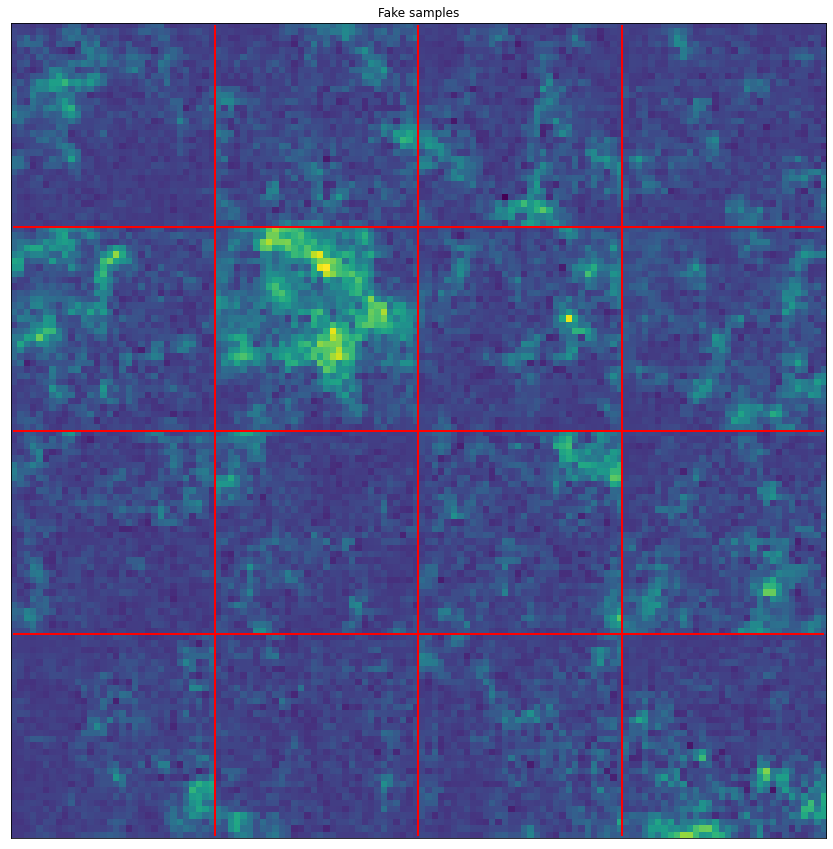

In [22]:
plt.figure(figsize=(15,15))
plot.draw_images(gen_sample,nx=4,ny=4);
plt.title("Fake samples");

# Evaluation of the sample quality

In [23]:
# Before computing the statistics, we need to invert the mapping
raw_images = backward(dataset.get_samples(2*N))
gen_sample_raw = backward(gen_sample)

PSD Frechet Distance: 2.879324018865976
PSD Score           : 0.34730373985274876



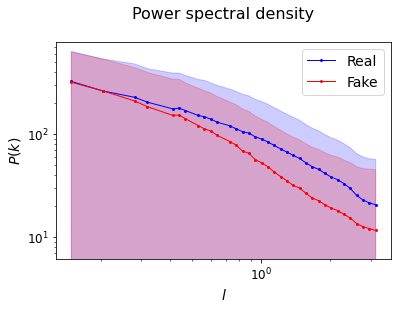

In [24]:
_ = evaluation.compute_and_plot_psd(raw_images[:N], gen_sample_raw, confidence='std')

/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:294: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array(pool.map(peak_count_arg, dat))
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:298: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array([np.log(pa+np.e) for pa in peak_arr])
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

Peak Frechet Distance: 2.199129441744816
Peak Score           : 0.45472539315675203



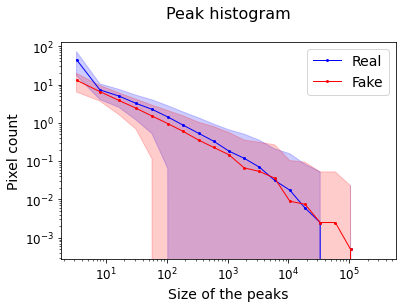

In [25]:
_ = evaluation.compute_and_plot_peak_count(raw_images[:N], gen_sample_raw, confidence='std')

Mass Frechet Distance: 0.6638140902467704
Mass Score           : 1.506445877984081



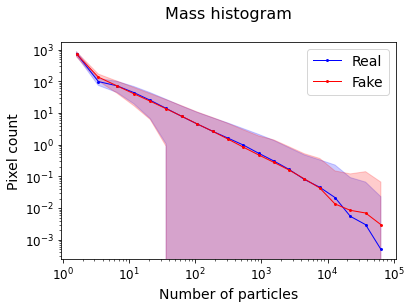

In [26]:
_ = evaluation.compute_and_plot_mass_hist(raw_images[:N], gen_sample_raw, confidence='std')

# Compute the scores

In [27]:
from cosmotools.metric.score import score_histogram, score_peak_histogram, score_psd
print('PSD score: {}'.format(score_psd(raw_images[:N],gen_sample_raw)))
print('Histogram score: {}'.format(score_histogram(raw_images[:N],gen_sample_raw)))
print('Peak histogram score: {}'.format(score_peak_histogram(raw_images[:N],gen_sample_raw)))

PSD score: 0.34730373985274876
Histogram score: 1.506445877984081


/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:294: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array(pool.map(peak_count_arg, dat))
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:298: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_arr = np.array([np.log(pa+np.e) for pa in peak_arr])
/Users/diego/3DcosmoGAN/notebooks/../cosmotools/metric/stats.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

Peak histogram score: 0.45472539315675203


#### For comparizon, the score obtained with real data

In [28]:
print('PSD score: {}'.format(score_psd(raw_images[:N],raw_images[N:2*N])))
print('Histogram score: {}'.format(score_histogram(raw_images[:N],raw_images[N:2*N])))
print('Peak histogram score: {}'.format(score_peak_histogram(raw_images[:N],raw_images[N:2*N])))

PSD score: 62.61754040745107
Histogram score: 34.40609187116897
Peak histogram score: 12.14716609125851
